# Per Fighter Analysis

in this notebook I'll focus on the per fighter dataset that I've constructed in order to get a general feel for what sort of trends we can see in the data. its possible this may inform the eventual dashboard, or that it will end up useless. who knows...

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from collections import Counter

%matplotlib inline
warnings.filterwarnings('ignore')  # gets rid of agitating boxes by plots

## Read in / quick analysis

First just read data in and get a handle on the usual shite like NULLs, unique value counts, ranges, etc...

In [2]:
df = pd.read_csv('../data/per_fighter_recent.csv')

df.head()

,fighter,odds,date,weight_class,gender,current_lose_streak,current_win_streak,avg_SIG_STlanded,avg_SIG_STpct,avg_TD_landed,...,td_landed_bout_mean,td_attempted_bout_mean,td_pct_bout_mean,sub_attempts_bout_mean,pass_bout_mean,rev_bout_mean,location_mode,date_amin,date_amax,bout_id_unique
0,Jun Yong Park,-138,2019-12-21,Middleweight,MALE,1,0,NaN,0.52170,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,"Busan, South Korea",2019-12-21,2019-12-21,['a1d134d4b20108d35642cb5c1ff2c55b']
1,Aalon Cruz,-190,2020-02-29,Featherweight,MALE,0,0,9.04,0.40000,0.0,...,0.0,1.000000,0.000000,0.0,0.000000,0.0,"Norfolk, Virginia, USA",2020-02-29,2020-02-29,['c8e695a49080fdac9137cd848fb8ca8d']
2,Aaron Phillips,475,2020-07-15,Bantamweight,MALE,2,0,NaN,NaN,0.0,...,0.0,0.500000,0.000000,0.5,0.500000,0.5,"['Abu Dhabi, Abu Dhabi, United Arab Emirates' ...",2014-05-24,2020-07-15,['571c2a7c29b76edaf0b9cad8c2b57d7d' '9d48bf025...
3,Aaron Riley,220,2013-07-27,Lightweight,MALE,1,0,36.00,0.36875,1.0,...,1.0,2.666667,0.123333,0.0,1.333333,0.0,"['Denver, Colorado, USA' 'Las Vegas, Nevada, U...",2010-05-29,2013-07-27,['4ecde1cf1408af7182d5b541a1d2a795' '5b3eab509...
4,Aaron Rosa,315,2012-03-02,Light Heavyweight,MALE,0,1,NaN,NaN,0.0,...,0.0,0.500000,0.000000,0.0,0.000000,0.0,"['Anaheim, California, USA' 'Sydney, New South...",2011-06-11,2012-03-02,['3c3697a651acc0e221012d5dfac92183' '512bbda44...


<AxesSubplot:>

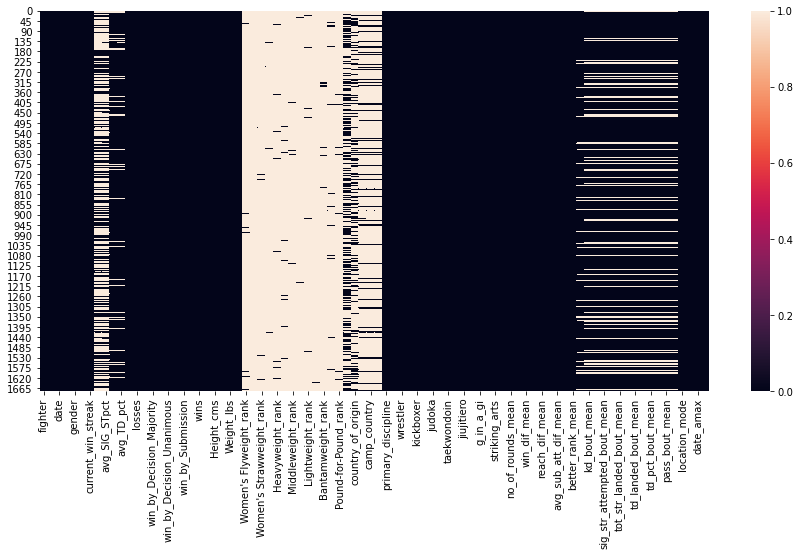

In [55]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.heatmap(df.isnull(), ax=ax)

probs should reduce this down to just the columns with NULLs in it for readability actually...

looks like we loose about 100 fighters nationalities compared to the size of that file. I guess we're going to have to do some more thorough cleaning of the data prior to the join, most likely on the per_fight csv rather than the nationality one

<AxesSubplot:>

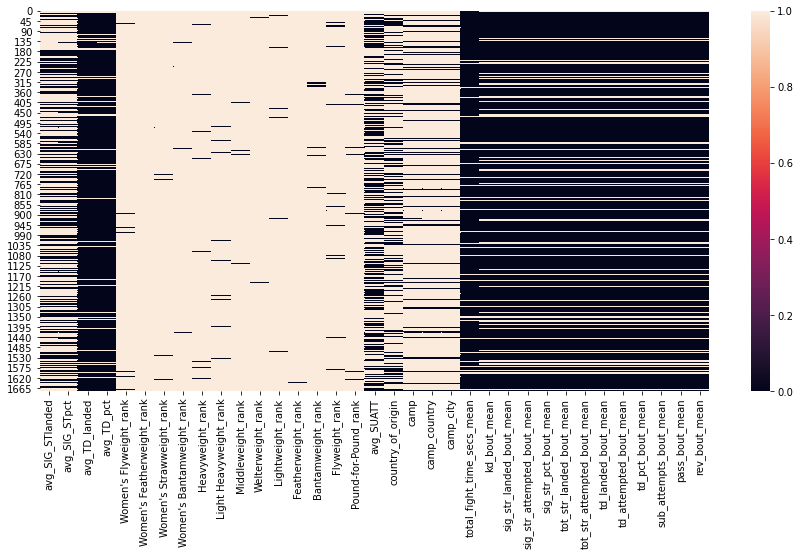

In [56]:
nulls = df.isnull()
nulls = nulls.loc[:, nulls.any()].columns  # get only columns with at least one NULL in

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(df[nulls].isnull(), ax=ax)

The rank variables are massively NULL, which is to be expected as only the top 15 fighters in each weightclass are ranked, though I guess since I'm not scraping current ranks, its possible for fighters who havent fought since loosing / gaining rank status wil incorrectly have a filled or NULL value in these columns respectively (especially true for retired fighters who went out relatively well respected). 

Beyond that we see that camp dataset is largely useless which to be fair is as expected. We also see that the mean statistics per fighter are often NULL for the same row i.e. a given fighter will be all NULL for these columns or not. It remains to be seen why that might be the case.

for the default second graph we'll do the unique value count of the non numeric columns just to get a feel for how much variety we're seeing there.

<AxesSubplot:>

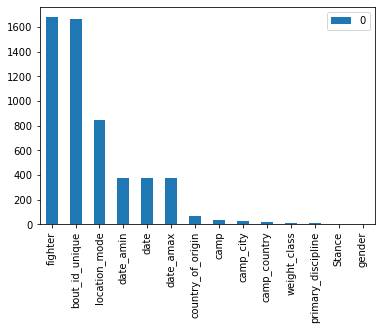

In [57]:
objs = df.select_dtypes(include=[object])
objs = pd.DataFrame(objs.nunique())
objs.sort_values(by=0, ascending=False, inplace=True)
objs.plot(kind='bar')

I'm supprised by location_mode having so many unqiue values, as that points to the city most commonly fought in, which I expected to be majority Vegas? I guess the next thing I'll look at is some spatial analysis then.

## Aforementioned Spatial Analysis Then

choropleth with the boiiiiis...

In all seriousness, we'll choropleth both country of origin and location_mode. First up, we'll cover the issue with location_mode. This variable comes wth it a question of what to do with multimodal values, which currently are saved as lists which is obviously a massive knob. The obvious options would be:

- pick a random mode to be the true mode
- pick the mode which is otherwise the most popular under the assumption that given more fights, this will be the location the fighter will revisit most often
- split the vote between all options either with or without weighting

beyond that the locations are also given as (city, country) pairings, or occasionally (city, region, country), so there is also the question of how gritty we can plot. I'm thinking in particular that splitting the US by state but everything else by country would be a decent way to do it?

for country_of_origin things look a lot more straight forwards, although some of the country names might need a bit of editing to match up to the standard polygon names (i.e. 'Russian Federation' isnt how Russia is typically labelled). 

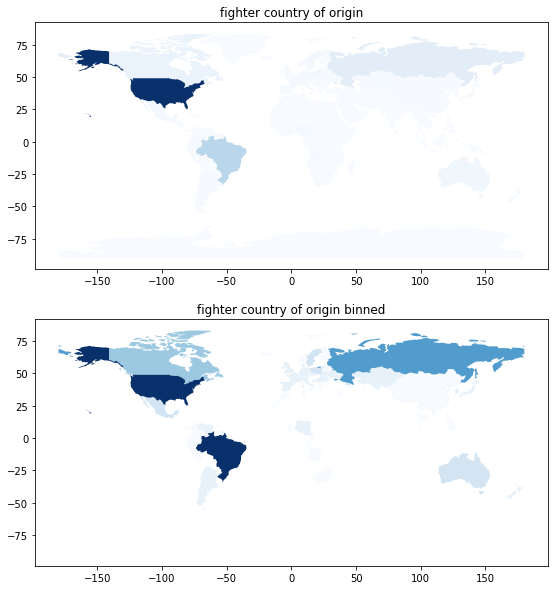

In [33]:
countries_polygons = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries_polygons.drop(['pop_est', 'gdp_md_est'], axis=1, inplace=True)

countries_of_origin = pd.DataFrame(df.groupby('country_of_origin').count()['fighter']).reset_index()
country_map = [['Hong Kong', 'China'],
               ['United States', 'United States of America'],
               ['Wales', 'United Kingdom'],
               ['Scotland', 'United Kingdom'],
               ['England', 'United Kingdom'],
               ['Czech Republic', 'Czechia'],
               ['Russian Federation', 'Russia'],
               ['North Macedonia', 'Macedonia'],
               ['Democratic Republic Congo', 'Congo'],
               ['Bosnia Herzegovina', 'Bosnia and Herz.'],
               ['Northern Mariana Islands', 'Philippines'],
               ['Guam', 'Philippines']]

for country in country_map:
    countries_of_origin.loc[countries_of_origin.country_of_origin == country[0], 'country_of_origin'] = country[1]

countries_of_origin = pd.merge(countries_of_origin, countries_polygons, left_on='country_of_origin',
                               right_on='name', how='outer')
countries_of_origin.fighter.fillna(0, inplace=True)
countries_of_origin = gpd.GeoDataFrame(countries_of_origin)


bins = [0, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, float('inf')]
labels = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 51]
countries_of_origin['fighter_binned'] = pd.cut(countries_of_origin['fighter'], bins=bins, labels=labels)

fig, ax = plt.subplots(2, figsize=(15, 10))

countries_of_origin.plot(column='fighter', cmap='Blues', figsize=(7.5, 5), ax=ax[0])
ax[0].set_title('fighter country of origin')
countries_of_origin.plot(column='fighter_binned', cmap='Blues', figsize=(7.5, 5), ax=ax[1])
ax[1].set_title('fighter country of origin binned')

plt.show()

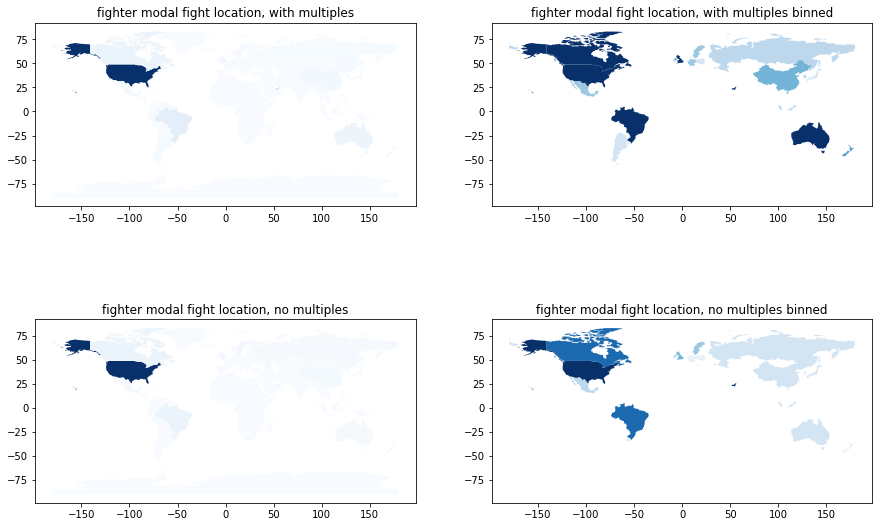

In [58]:
replacements = {'USA': 'United States of America',
                'Singapore': 'Malaysia'}

modal_locs_list = df['location_mode'].tolist()

modal_locs = [loc.replace('\n', '').split("' '")[0].split(',')[-1].strip() for loc in modal_locs_list]
modal_locs = [replacements.get(x, x) for x in modal_locs]
modal_locs = pd.DataFrame.from_dict(dict(Counter(modal_locs)), orient='index').reset_index()
modal_locs.columns = ['loc', 'count']

modal_locs_no_multis = [loc.replace('\n', '').split("' '")[0].split(',')[-1].strip() for loc in modal_locs_list
                        if '[' not in loc]
modal_locs_no_multis = [replacements.get(x, x) for x in modal_locs_no_multis]
modal_locs_no_multis = pd.DataFrame.from_dict(dict(Counter(modal_locs_no_multis)), orient='index').reset_index()
modal_locs_no_multis.columns = ['loc', 'count_no_multis']

modal_locs = pd.merge(modal_locs, countries_polygons, left_on='loc', right_on='name', how='outer')
modal_locs = pd.merge(modal_locs, modal_locs_no_multis, on='loc', how='outer')
modal_locs['count'].fillna(0, inplace=True)
modal_locs['count_no_multis'].fillna(0, inplace=True)
modal_locs = gpd.GeoDataFrame(modal_locs)

bins = [0, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50, float('inf')]
labels = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 51]
modal_locs['modal_loc_binned'] = pd.cut(modal_locs['count'], bins=bins, labels=labels)
modal_locs['modal_loc_no_multis_binned'] = pd.cut(modal_locs['count_no_multis'], bins=bins, labels=labels)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

modal_locs.plot(column='count', cmap='Blues', figsize=(7.5, 5), ax=ax[0, 0])
ax[0, 0].set_title('fighter modal fight location, with multiples')
modal_locs.plot(column='modal_loc_binned', cmap='Blues', figsize=(7.5, 5), ax=ax[0, 1])
ax[0, 1].set_title('fighter modal fight location, with multiples binned')
modal_locs.plot(column='count_no_multis', cmap='Blues', figsize=(7.5, 5), ax=ax[1, 0])
ax[1, 0].set_title('fighter modal fight location, no multiples')
modal_locs.plot(column='modal_loc_no_multis_binned', cmap='Blues', figsize=(7.5, 5), ax=ax[1, 1])
ax[1, 1].set_title('fighter modal fight location, no multiples binned')

plt.show()

as expected the USA comes out as king, primarily due to all the las vegas fights (~1000 / 1600 fighters have at least one mode occuring there). Interesting to see some of the other countries that have the most modes, as they dont really match up with the fighters countris of origin as we know them. (for instance we dont see many Canadian or Arabian fighters, yet these two countries each have over a hundred modes. 

the graphs labelled 'no multiples' have had multimodals removed entirely. not sure if that was the best way to deal with them but thats how ive opted to do it. hasnt made a huge difference other than reducing the numbers in like UK, Canada, Brazil and most interstingly australia. I'd be interested to know why that migth be - potentially lots of smaller fighters who'd prefer to fight on local cards / vegas cards only?

next up, I'll have a fiddle with the mean stats. I'd imagine this will be a kooky one :O

## Discipline Mean Statistic Scatter Plots

we want to have a look at how each discipline typically behaves in terms of stats. for now, we'll use all fighters from each discipline to inform this but obviously ranked vs unranked would be a meaningful expanion on this...

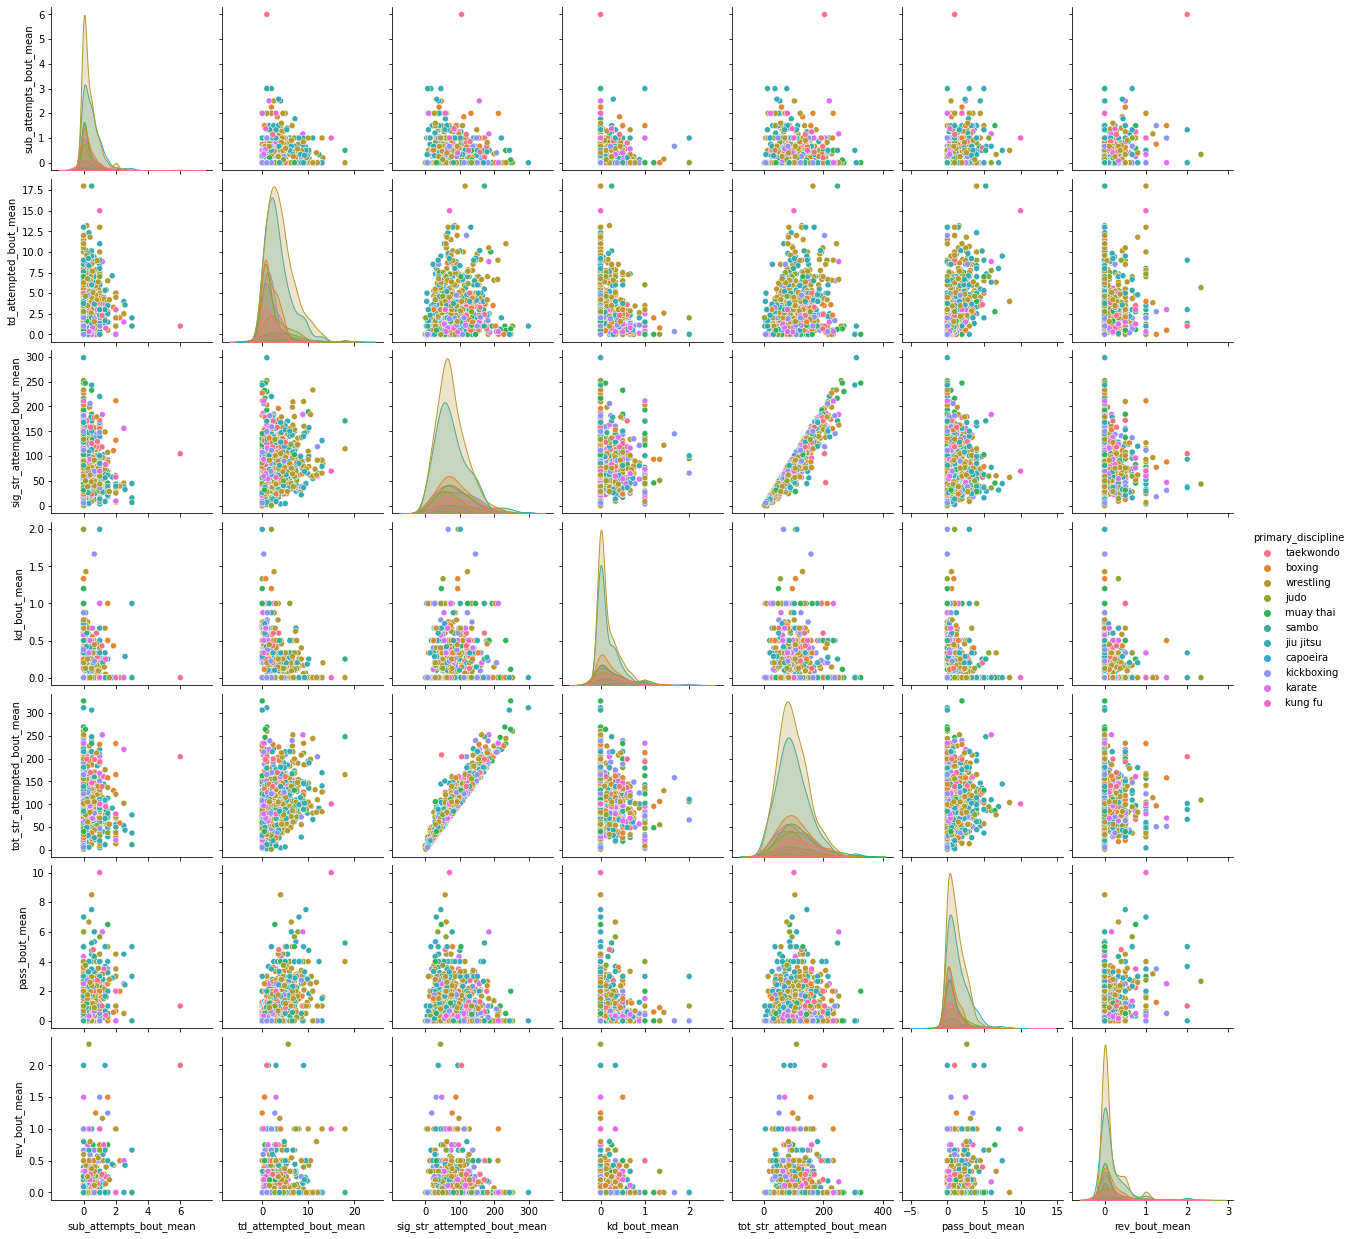

In [78]:
cols = ['sub_attempts_bout_mean', 'td_attempted_bout_mean', 'sig_str_attempted_bout_mean', 'kd_bout_mean',
        'tot_str_attempted_bout_mean', 'pass_bout_mean', 'rev_bout_mean']

discipline_stats = df[['primary_discipline'] + cols].dropna()
discipline_stats = discipline_stats[discipline_stats['primary_discipline'] != 'mixed']  # mixed muddies the waters

sns.pairplot(vars=cols, data=discipline_stats, hue="primary_discipline")

hmmm... could be interesting if the user could zoom in to individual plots. Prehaps this is a good candidate for the dashboard then? I'd like to quickly try to replot this with the reduced discipline groupings since there are too many groups for me to read the differences in the colours here to me.

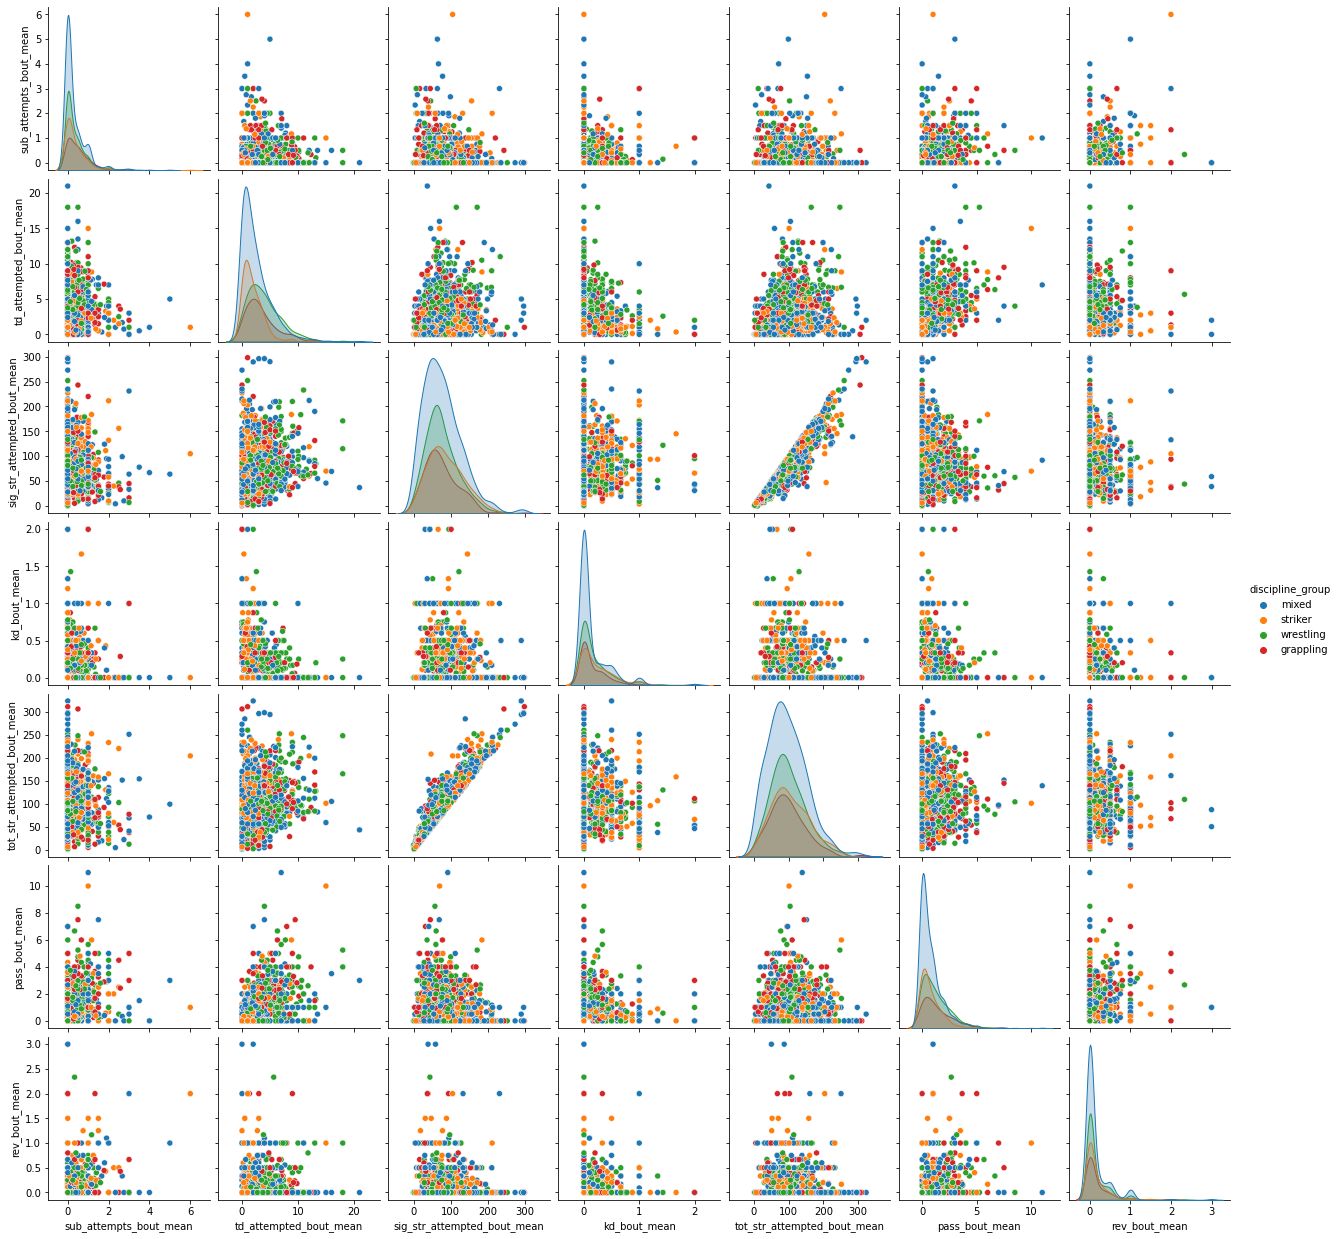

In [90]:
cols = ['sub_attempts_bout_mean', 'td_attempted_bout_mean', 'sig_str_attempted_bout_mean', 'kd_bout_mean',
        'tot_str_attempted_bout_mean', 'pass_bout_mean', 'rev_bout_mean']
striking_arts = ['boxing', 'muay thi', 'kickboxing', 'karate', 'taekwondo', 'kung fu']
wrestling_arts = ['wrestling', 'sambo', 'judo']

discipline_stats = df[['primary_discipline'] + cols].dropna()

conditions = [discipline_stats['primary_discipline'].isin(striking_arts), 
              discipline_stats['primary_discipline'].isin(wrestling_arts),
              discipline_stats['primary_discipline'] == 'jiu jitsu',
              discipline_stats['primary_discipline'] == 'mixed']
choices = ['striker', 'wrestling', 'grappling', 'mixed']
discipline_stats['discipline_group'] = np.select(conditions, choices)

discipline_stats.drop('primary_discipline', axis=1, inplace=True)
discipline_stats = discipline_stats[discipline_stats['discipline_group'] != '0']

sns.pairplot(vars=cols, data=discipline_stats, hue="discipline_group")

I guess from here you can start to see some more patterns to be fair, such as:

- more knockdowns (kd) in a bout tends to mean fewer takedowns, and the strikers tend to cause the knockdowns not the takedowns
- grapplers and wrestlers tend to make fewer attempts at striking than strikers or mixed martial artists.
- wrestlers dont make many submission attempts or reversals compared to the other styles, showingthey tend to sit on people

I wonder if theres some other way of classifying the fighters that could serve to plot more interesting graphs here...? I could next view some violin plots of this info rather than the distributions / scatter plots prehaps? 

## Discipline Mean Statistics Violin Plots

who saw that title coming after the last sentence?

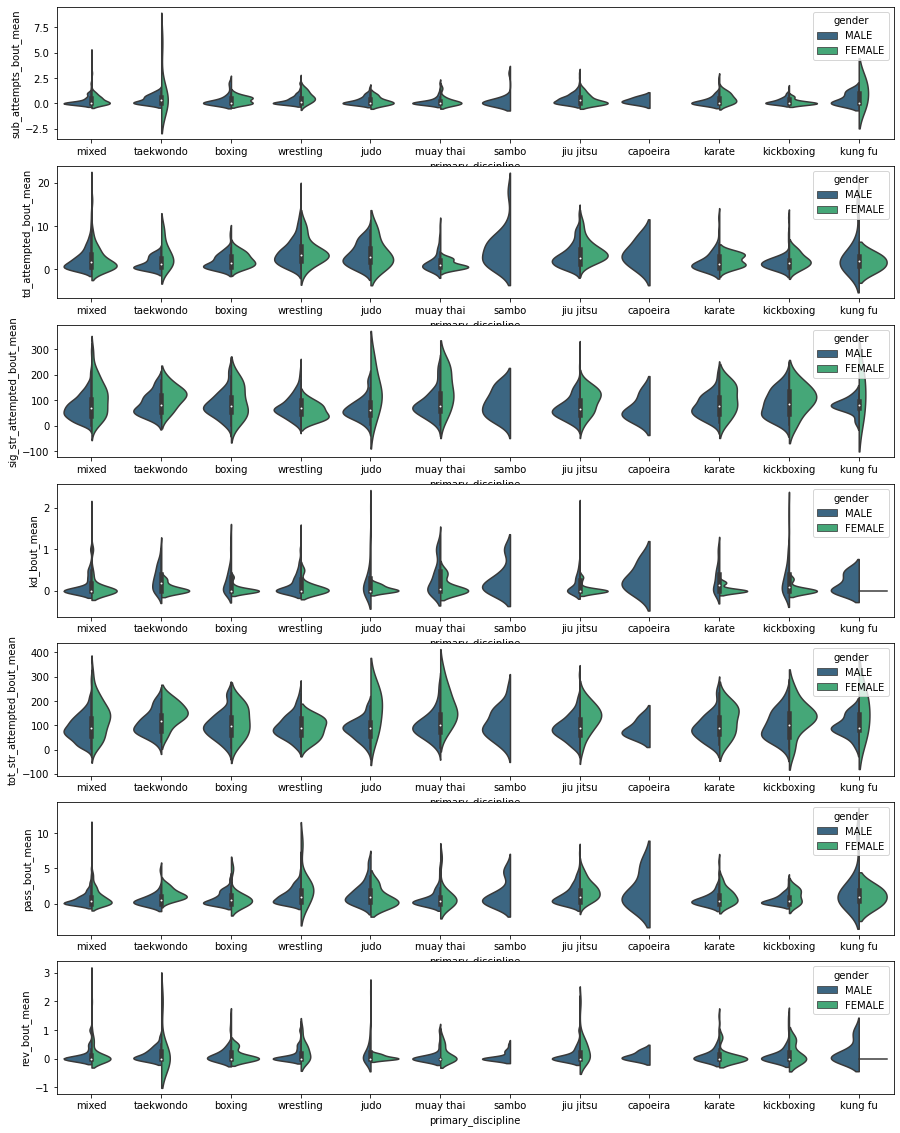

In [30]:
cols = ['sub_attempts_bout_mean', 'td_attempted_bout_mean', 'sig_str_attempted_bout_mean', 'kd_bout_mean',
        'tot_str_attempted_bout_mean', 'pass_bout_mean', 'rev_bout_mean']

fig, ax = plt.subplots(7, figsize=(15, 20))

for col in range(len(cols)):
    sns.violinplot(x="primary_discipline", y=cols[col], hue="gender", 
                   data=df, palette="viridis", split=True, ax=ax[col])

interesting to see female fighters generally seem to have a higher output than the males, though i guess that fits with the general perception of womens fight more frequently going the distance and having little stopping power (more time per bought to attempt strikes). This could also explain why tot strikes attempted is generally lower for striking arts like karate or muay thai especially as compared to to arts like wrestling or sambo in which the striking output seems to have a higher range.

next I think it could be cool to see what happens to win / loss ratio as fighters age - prehaps we see the point where the fighters become shit?

## Success by Age Scatter plots

not too sure what exactly to plot here so i'll chuck a few variants on

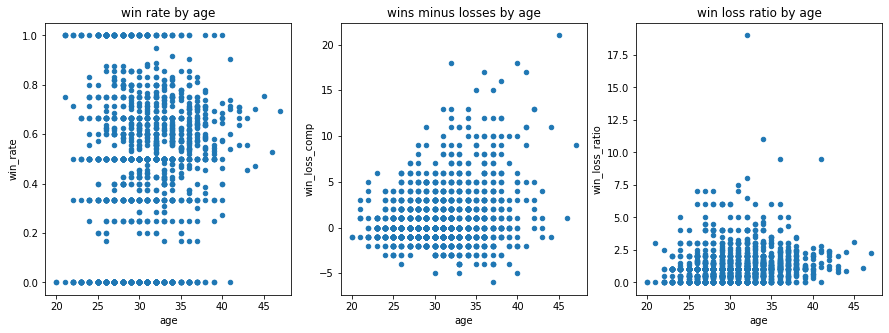

In [32]:
age_wins = df[['age', 'wins', 'losses']]
age_wins['win_loss_ratio'] = (age_wins['wins'] / age_wins['losses']).fillna(1)
age_wins['win_loss_comp'] = age_wins['wins'] - age_wins['losses']
age_wins['win_rate'] = age_wins['wins'] / (age_wins['wins'] + age_wins['losses'])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
age_wins.plot(kind='scatter', x='age', y='win_rate', ax=ax[0], title='win rate by age')
age_wins.plot(kind='scatter', x='age', y='win_loss_comp', ax=ax[1], title='wins minus losses by age')
age_wins.plot(kind='scatter', x='age', y='win_loss_ratio', ax=ax[2], title='win loss ratio by age')

plt.show()

well I've learnt nothing... :O 

I guess you'd expect the highest win count to appear with older people, but I'm suppprised we dont see a peak then retrace pattern. I suppose the win / loss ratio plays that way prehaps? generally quite hard to tell any real stories with these. Win rate could work as a bar chart per discipline?

## Win Rate by discipline Bar Chart

<AxesSubplot:xlabel='primary_discipline'>

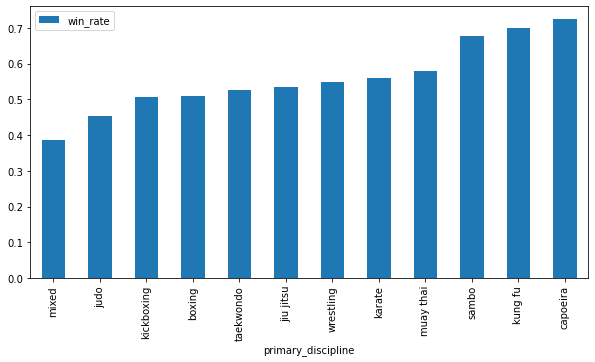

In [40]:
df['win_rate'] = df['wins'] / (df['wins'] + df['losses'])

disciplines = df.groupby('primary_discipline').mean().reset_index().sort_values(by='win_rate')
disciplines.plot(kind='bar', x='primary_discipline', y='win_rate', figsize=(10, 5))

I think it might be fair to ignore the highest preforming disciplines here, as they incidentally match up to the least popular arts so probably are more likely to be swung by a few top level talents (Khabib, Weili, Tony Furguson, ...)

Similarly the fact that 'mixed' has the lowest win rate could also be seen as slightly unfair as we've set fighters without discipline information to default to 'mixed', so you get alot of low level talent in that category loweringt the score either by being a bit shit or by having very few fights full stop, leading to the few losses on their record having a much larger influence on the win rate. To that end, I wonder if the same graph plotted per discipline rather than per fighter per discipline would be beneficial?

<AxesSubplot:xlabel='primary_discipline'>

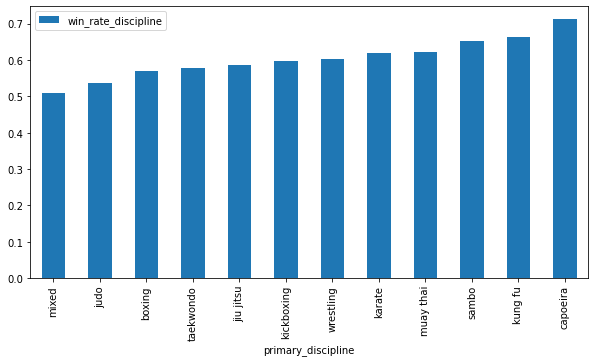

In [44]:
disciplines = df.groupby('primary_discipline').sum().reset_index()
disciplines['win_rate_discipline'] = disciplines['wins'] / (disciplines['wins'] + disciplines['losses'])
disciplines.sort_values(by='win_rate_discipline').plot(kind='bar', x='primary_discipline', y='win_rate_discipline', figsize=(10, 5))

interestingly not much different. the rate is typically higher than it was using the alternate method, but the order is largely unchanged at leat in any significant way. You see some swaps toward the bottom though, with kickboxers in particular seemingly being propped up before by a few overachievers.